# Fit Hologram parameters For AuxTel on July 2021 scan to make a Figure for PCWG


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : Feb 18st 2022
- last update : February 10th 2022
- Last update : Tuesday 15th 2022 , new values for c_Z0 = 184.45 mm and c_d1=19.4  mm,
- version 4


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is


plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
FLAG_HOMOTHETIE   = True
FLAG_STEPOPTIMIZE = True

# constants

- all transverse physical coordinates are in mm and relative to beam optical center (at CCD center)

In [3]:
# conversion in good inits
u_radtodeg=180.0/np.pi
u_degtorad=np.pi/180.
u_mtomm=1e3

- all constants are refered as $c\_$

In [4]:
c_F=18.0*1.2*u_mtomm # Auxtel Focla length # ou 13.7m

In [5]:
c_F

21599.999999999996

In [6]:
c_Z1=200.   # mm, distance between hologram and source plane during holo recording
c_Z0=184.45 # mm, distance between hologram and CCD plane for observations 

In [7]:
#c_d1=20.0 # mm, distance between the sources during recording 
c_d1=19.4 # mm, distance between the sources during recording 

In [8]:
c_X_Oh=7  # mm , x-coordinates of the hologram optical center in the CCD ref frame
c_Y_Oh=5 # mm , y-coordinate of the hologram optical center in the CCD ref frame

In [9]:
c_beta0=10 #degree , angle of rotation of hologram source axis wrt CCD  

In [10]:
c_wl0= 639e-6 # mm, recording wavelength 

# Functions

- $(X,Y)$ : coordinates in CCD frame with telecope optical center as the origin
- $(x,y)$ : coordinates in hologram frame with telecope optical center as the origin the same reference axis as the CCD
- $(x_1,y_1)$ : coordinates in hologram reference frame, with telecope optical center as the origin, such the two sources A $(x_1(A),y_1(A))$ and B $(x_1(B),y_1(B))$ have coordinates:
$$
x_1(A)= x_1 (0)-d_1/2 
$$
$$
y_1(A)= y_1(0)
$$
$$
x_1(B)= x_1 (0)+d_1/2 
$$
$$
y_1(B)= y_1(0)
$$

## Homothetie of coordinate system between Hologram and CCD

with $F$ as telescope focale : $\delta \theta = \frac{dx}{F}$
$$
\tan \alpha = \frac{X_{CCD}}{F} = \frac{x_H}{F-D_{CCD}}
$$
- contraction of length from CCD to Hologram
$$
x_H = \left(1-\frac{D_{CCD}}{F}\right) X_{CCD}
$$

- dilatation from Hologram to CCD

$$
X_{CCD} = \frac{1}{1-\frac{D_{CCD}}{F}} x_{H}
$$

In [11]:
def XYtoxy(XY,Z):
    """
    XYtoxy(XY,Z): convert coordinates in CCD plane (R) to the CCD plane projected at hologram plane.
    The origin of the coordinates is always the optical center of the telescope.
    
    The coordinates undergo an homothetie.
    
    
    
    input parameters
    - XY : numpy array of the 2-coordinates in CCD in mm
    - Z : distance between hologram and CCD in mm (positive)
    
    output parameter 
    - xy : numpy array of the 2-coordinates in  in mm at hologram position
    """
    XY=np.array(XY)
    
    if FLAG_HOMOTHETIE:
        xy=(1-Z/c_F)*XY  #small contraction from CCD to Hologram
    else:
        xy=XY
    
    return xy  

In [12]:
def XYtoxy_2D(X,Y,Z):
    """
    XYtoxy(XY,Z): convert coordinates in CCD plane (R) to the CCD plane projected at hologram plane.
    The origin of the coordinates is always the optical center of the telescope.
    
    The coordinates undergo an homothetie.
    
    
    
    input parameters
    - XY : numpy array of the 2-coordinates in CCD in mm
    - Z : distance between hologram and CCD in mm (positive)
    
    output parameter 
    - xy : numpy array of the 2-coordinates in  in mm at hologram position
    """
    if FLAG_HOMOTHETIE:
        x=(1-Z/c_F)*X  #small contraction from CCD to Hologram
        y=(1-Z/c_F)*Y  #small contraction
    else:
        x=X
        y=Y
    
    return x,y  

In [13]:
def xytoXY(xy,Z):
    """
    xytoXY(xy,Z): convert coordinates in hologram plane to CCD plane.
    The origin of the coordinates is always the optical center of the telescope.
    
    input parameters
    - xy : numpy array of the 2-coordinates in  in mm
    - Z : distance between hologram and CCD in mm (positive)
    
    output parameter 
    - XY : numpy array of the 2-coordinates in CCD in mm
    
    """
    xy=np.array(xy)
    
    if FLAG_HOMOTHETIE:
        XY=1./(1-Z/c_F)*xy #small dilatation from hologram to CCD
    else:
        XY=xy
    
    return XY  

In [14]:
def xytoXY_2D(x,y,Z):
    """
    xytoXY(xy,Z): convert coordinates in hologram plane to CCD plane.
    The origin of the coordinates is always the optical center of the telescope.
    
    input parameters
    - xy : numpy array of the 2-coordinates in  in mm
    - Z : distance between hologram and CCD in mm (positive)
    
    output parameter 
    - XY : numpy array of the 2-coordinates in CCD in mm
    
    """
    if FLAG_HOMOTHETIE: 
        X=1./(1-Z/c_F)*x #small dilatation
        Y=1./(1-Z/c_F)*y #small dilatation
    else:
        X=x
        Y=y
    
    return X,Y  

## Rotation from Hologram projected- CCD frame to hologram reference plane

In [15]:
def xytox1y1(xy,beta,x0,y0):
    """
    xytox1y1(xy,alpha): convert coordinates in hologram plane (same ref axis as CCD) with origin at O, the optical center
    of the telescope the instrinsic hologram frame with origin Oh, the optical center of the hologram.
    
    Both system are rotated by an angle beta such the Oh-x1 axis is parallel to sources A,B)
    
    input parameters
    - xy : numpy array of the 2-coordinates in hologram which ref axis are those of CCD and origin is O
    - beta : angle in degree
    
    - (x0,y0) : coordinate of hologram geometrical Oh (projected at hologram plane)
    
    output parameter 
    - x1y1 : mm, numpy array of the 2-coordinates in the intrinsic hologram frame
    
    """
    
    cos_beta=np.cos(beta*u_degtorad)
    sin_beta=np.sin(beta*u_degtorad)
    x=xy[0]-x0
    y=xy[1]-y0   
    x1y1=np.array([cos_beta*x+sin_beta*y,-sin_beta*x+cos_beta*y])
    return x1y1
    
 

In [16]:
def xytox1y1_2D(x,y,beta,x0,y0):
    """
    
    2D version of function xytox1y1()
    
    convert coordinates in hologram plane (same ref axis as CCD) with origin at O, the optical center
    of the telescope the instrinsic hologram frame with origin Oh, the optical center of the hologram.
    
    Both system are rotated by an angle beta such the Oh-x1 axis is parallel to sources A,B)
     
    
    input parameters
    - x,y : 2D-numpy array of the 2-coordinates in hologram plane which ref axis are those of CCD and origin is O
    - alpha : angle in degree
    
    - (x0,y0) : coordinate of hologram geometrical Oh in CCD axis frame projected at hologram plane
    Usually x0,y0 are 2D arrays representing 
    the various hypothesis on Oh position when computing a Chi2 
    
    output parameter 
    - x1,y1 : mm, 2D-numpy array of the 2-coordinates in the intrinsic hologram frame
    
    """
    
    cos_beta=np.cos(beta*u_degtorad)
    sin_beta=np.sin(beta*u_degtorad)
    
    x=x-x0
    y=y-y0
    
    x1=cos_beta*x+sin_beta*y
    y1=-sin_beta*x+cos_beta*y
       
    
    return x1,y1

## Rotation from hologram reference plane to from Hologram projected - CCD frame 

In [17]:
def x1y1toxy(x1y1,beta,x0,y0):
    """
    x1y1toxy(x1y1,beta,x0,y0): convert coordinates in the intrinsic hologram frame R1h to the hologram frame Rh
    with same axis as CCD , both frame being rotated by a relative angle beta
    
    input parameters
    - x1y1 : mm, numpy array of the 2-coordinates in the intrinsic hologram frame  R1h
    - beta : angle in degree
    - (x0,y0) : coordinate of hologram geometrical Oh in CCD axis frame but projected at hologram plane
    
    output parameter 
     - xy : numpy array of the 2-coordinates in hologram which ref axis are those of CCD mm
   
    
    """
    
    cos_beta=np.cos(beta*u_degtorad)
    sin_beta=np.sin(beta*u_degtorad)
    
    x1=x1y1[0]
    y1=x1y1[1]
    
    # note the coordinate are shifted wrt Oh point coordinates in CCD 
    xy=np.array([cos_beta*x1-sin_beta*y1+x0,sin_beta*x1+cos_beta*y1+y0])
    return xy

In [18]:
def x1y1toxy_2D(x1,y1,beta,x0,y0):
    """
    
    2D version of x1y1toxy(x1y1,beta,x0,y0):
    x1y1toxy_2D(x1,y1,alpha): convert coordinates in the intrinsic hologram frame  to the hologram frame 
    with same axis as CCD by an angle beta 
    
    input parameters
    - x1,y1 : mm, 2D numpy array of the 2-coordinates in the intrinsic hologram frame  
    - alpha : angle in degree
    - (x0,y0) : coordinate of hologram geometrical Oh in CCD axis frame but projected at hologram plane
    
    output parameter 
     - x,y : 2D numpy array of the 2-coordinates in hologram which ref axis are those of CCD mm
   
    
    """
    
    cos_beta=np.cos(beta*u_degtorad)
    sin_beta=np.sin(beta*u_degtorad)
    
    
    x=cos_beta*x1-sin_beta*y1+x0
    y=sin_beta*x1+cos_beta*y1+y0
    return x,y

## Distances calculation

In [19]:
def dist1_to_source(xy,xy_s):
    """
    dist1_to_source(xy,xy_s) : distance between a point M(x,y) to a source S(x_S,y_s) at hologram recording phase.
    (That is why Z1 is used,  not Z0).
    
    The alpha hologram rotation angle is not important provided both point M and source S have the same reference axis
    
     input parameters
    - xy   : mm, 1D-numpy array of the 2-coordinates of point M in the  hologram frame  
    - xy_s : mm, 1D-numpy array of the 2-coordinates of the source in the  hologram frame  
    
    
    output parameter:
    return the 3d distance 
    
    """
    
    return np.sqrt(c_Z1**2+ (xy[0]-xy_s[0])**2+ (xy[1]-xy_s[1])**2)

In [20]:
def ddist1_to_source(x,y,x_s,y_s):
    """
    ddist1_to_source(xy,xy_s) : distance between a point M(x,y) to a source S(x_S,y_s) at hologram recording phase.
    (That is why Z1 is used,  not Z0).
    
    more efficient than dist1_to_source(xy,xy_s) because x,y are 2D numpy arrays.
    
    The alpha hologram rotation angle is not important provided both point M and source S have the same reference axis
    
     input parameters
    - x,y   : mm, 2D-numpy array of the 2-coordinates of point M in the  hologram frame  
    - x,y_s : mm, scalar the 2-coordinates of the source in the  hologram frame  
    
    
    output parameter:
    return the distance in 3D in a 2D numpy array
    
    Note : Either (x,y) are 2 2D-numpy array and (x_s,y_s) are 2 scalars 
           Or  (x,y) are 2 scalars and (x_s,y_s) are 2 2D-numpy arrays
    
    """
    
    return np.sqrt(c_Z1**2 + (x-x_s)**2+ (y-y_s)**2)

# Model of phase difference

## Phase difference during recording

- Optical path difference $OP(M)$ at a point M(x,y) during recording

$$
OP(M) = d(M,A) - d(M,B)
$$

- in Hologram reference frame ($Z_1$ distance between source plane and hologram plane during recording)

$$
OP(x,y) = \sqrt{(x-x_{1A})^2+(y-y_{1A})^2+Z_1^2} -  \sqrt{(x-x_{1B})^2+(y-y_{1B})^2+Z_1^2} \equiv d_{1A}(M) - d_{1B}(M)
$$

- Phase difference imprinted in hologram 

$$
\Delta \Phi(M) = \frac{2\pi}{\lambda_0} \left( OP(M) \right) = \frac{2\pi}{\lambda_0} \left( d_{1A}(M) - d_{1B}(M) \right)
$$

- This Phase difference is converted in an interference pattern emulsion index modulation:
(within a constant phase shift : here we assume the sources are exactly at the same phase and the interference and the maximum of interference is at the middle of segment A-B)

$$
n(M) = \frac{n_0}{2} \left( \cos(\Delta \Phi(M))+1 \right)  
$$


- the central maximum of interference for $M=O_1$ is $\Delta \Phi(M) = 0$ such $n(O_1) = n_0$




$$
\frac{2 \pi}{\lambda_0} \left. \left( \frac{\partial}{\partial x} d_{1A}(x,y) - \frac{\partial}{\partial x}d_{1B}(x,y) \right)\right|_{x=0,y=0} \delta x = \pi 
$$

## Isophases 

### Dispersion axis angle 

- The direction of dispersion axis is perpendicular to iso-phase lines

$$
\tan \beta = \frac{dy}{dx} = \frac{\frac{\partial \Delta \Phi}{\partial x}}{\frac{\partial \Delta \Phi}{\partial y}}
$$


$$
\frac{\partial \Delta \Phi(x,y) }{\partial x} = \frac{2 \pi}{ \lambda_0} \left( \frac{x-x_{1A}}{d_{1A}(x,y)} - \frac{x-x_{1B}}{d_{1B}(x,y)} \right)
$$

$$
\frac{\partial \Delta \Phi(x,y) }{\partial y} = \frac{2 \pi}{ \lambda_0} \left( \frac{y-y_{1A}}{d_{1A}(x,y)} - \frac{y-y_{1B}}{d_{1B}(x,y)} \right)
$$


$$
\tan \beta = \frac{dy}{dx} = \frac{\frac{x-x_{1A}}{d_{1A}(x,y)} - \frac{x-x_{1B}}{d_{1B}(x,y)}}
{\frac{y-y_{1A}}{d_{1A}(x,y)} - \frac{y-y_{1B}}{d_{1B}(x,y)}}
$$


## Line density

- let $s$ the curviligne coordinate along lines perpendicular to iso-phases.

$$
ds = \frac{\partial s}{\partial x} dx +  \frac{\partial s}{\partial y} dy 
$$

- $N_{eff}$ must be proportionnal to $\frac{\partial \Delta \Phi(x,y)}{ \partial s}$:

$$
N_{eff} = K \frac{\partial \Delta \Phi(x,y)}{ \partial s} = K \left( \frac{\partial x}{\partial s}\frac{\partial \Delta \Phi(x,y)}{ \partial x} + \frac{\partial y}{\partial s} \frac{\partial \Delta \Phi(x,y)}{ \partial y}  \right) = K\left( \cos \beta \frac{\partial \Delta \Phi(x,y)}{ \partial x} + \sin \beta \frac{\partial \Delta \Phi(x,y)}{ \partial y}  \right)
$$


$$
N_{eff}(x,y) = \frac{2 \pi}{\lambda_0} K \left( \cos \beta \left( \frac{x-x_{1A}}{d_{1A}(x,y)} - \frac{x-x_{1B}}{d_{1B}(x,y)} \right) + \sin \beta \left( \frac{y-y_{1A}}{d_{1A}(x,y)} - \frac{y-y_{1B}}{d_{1B}(x,y)} \right) \right)
$$

## to find the constant K

- suppose we move on a line $y=0$,  so $\cos \beta = 1, \sin \beta = 0$:
$$
\frac{\partial \Delta \Phi(x) }{\partial x} = \frac{\partial \Delta \Phi(x) }{\partial s} = \frac{2 \pi}{ \lambda_0} \left( \frac{x-x_{1A}}{d_{1A}(x)} - \frac{x-x_{1B}}{d_{1B}(x)} \right)
$$

$$
\frac{\partial \Delta \Phi(x) }{\partial y} = 0
$$

- to find the positions from where $\Delta \Phi(x_0 = 0 )= 0 $ change by half a cycle:
$$
x_+ = x_{0}+ \delta x \; {\rm such} \; \Delta \Phi(x_{0}+ \delta x) = \pi 
$$
and 
$$
x_- = x_{0} - \delta x \; {\rm such} \; \Delta \Phi(x_{0}- \delta x) = - \pi 
$$

and we define $D_{S0}$ the distance between any source to hologram geometrical center (at recording).
$$
d_{1A}(0) = d_{1B}(0) \equiv D_{S0} 
$$


$$
\Delta \Phi(x_+ )= \frac{2 \pi}{\lambda_0} \left. \left( \frac{\partial}{\partial x} d_{1A}(x,0) - \frac{\partial}{\partial x}d_{1B}(x,0) \right)\right|_{x=0,y=0} \delta x = \pi 
$$
$$
\Delta \Phi(x_+ )= \frac{2 \pi}{\lambda_0} \left. \left( \frac{\partial}{\partial x} d_{1A}(x,0) - \frac{\partial}{\partial x}d_{1B}(x,0) \right)\right|_{x=0,y=0} \delta x = \pi 
$$
$$
\Delta \Phi(x_+ )= \frac{2 \pi}{ \lambda_0 D_{S0}} \left( x_{1B}-x_{1A}\right) \delta x = \pi
$$

The distance between two minima of $n(x)$ at $x=x_0$ is

$$
2\delta x = \frac{\lambda_0 d_{S0}}{x_{1B}-x_{1A}} = \frac{\lambda_0 D_{S0}}{d_1}
$$

So 

$$
N_{eff}^{max} = \frac{1}{2\delta x} = \frac{d_1}{\lambda_0 D_{S0}}
$$

and

$$
N_{eff}(x,y) = N_{eff}^{max} \frac{\left( \cos \beta \left( \frac{x-x_{1A}}{d_{1A}(x,y)} - \frac{x-x_{1B}}{d_{1B}(x,y)} \right) + \sin \beta \left( \frac{y-y_{1A}}{d_{1A}(x,y)} - \frac{y-y_{1B}}{d_{1B}(x,y)} \right) \right)}{ \frac{d_1}{D_{S0}}}
$$

In [21]:
Neffmax= c_d1/c_wl0/ddist1_to_source(0,0,c_d1/2,0)
print(f"Neffmax={Neffmax:.1f}")

Neffmax=151.6


## Distance difference

In [22]:
def d_phi(x1y1):
    """  
    d_phi(x1y1) : distance difference at point(x1y1) during recording.
    Camculation donne in hoologram frame
    
    input parameters
    - x1y1   : mm, numpy array of the 2-coordinates of point M in the  intrinsic hologram frame  
         
    output parameter:
    return the angle d_alpha in degree
    
    """
    
    
    x1y1_A=np.array([-c_d1/2, 0]) # coordinate of source A
    x1y1_B=np.array([+c_d1/2, 0]) # coordinate of source B
    
    d1_A=dist1_to_source(x1y1,x1y1_A)  # distance to source A
    d1_B=dist1_to_source(x1y1,x1y1_B)  # distance to source B
    
    d_phi=d1_A-d1_B
   
    
    return d_phi

In [23]:
def dd_phi(x1,y1):
    """
    dd_alpha(x1,y1) : angle d_alpha of hologram dispersion axis un hologram intrinsic reference frame
    
    more efficient than d_alpha(x1y1,x1y1_0) because x1,y1 are a 2D numpy array
    
    input parameters are 2D numpy array
    - x1,y1   : mm, 2D numpy array of the 2-coordinates of point M in the  intrinsic hologram frame  
     
    
    output parameter:
    return the angle d_alpha in degree in a 2D numpy array
    
    
    Notes :
     - Either (x1,y1) may be 2 2D-numpy arrays and x1_0,y1_0 two scalars : to get the d_alpha(x1,y1)
     - Or fix (x1,y1) as two scalars where the angle is measured and (x1_0,y1_0) are 2 2D numpy arrays
     for scanning in chi2 function the best position for parameters (x1_0,y1_0) 
    
    """
    
    
    x1_A=-c_d1/2 # coordinate of source A
    y1_A=0.        # coordinate of source A
    
    x1_B=c_d1/2 # coordinate of source B
    y1_B=0        # coordinate of source B
    
    dd1_A=ddist1_to_source(x1,y1,x1_A,y1_A)  # distance to source A in a 2D numpy array
    dd1_B=ddist1_to_source(x1,y1,x1_B,y1_B)  # distance to source B
    
    
    dd_phi=dd1_A-dd1_B
    
    return dd_phi # in a 2D numpy array

In [24]:
def d_alpha(x1y1):
    """
    d_alpha(x1y1) : angle d_alpha of hologram dispersion axis un hologram intrinsic reference frame
    
    
    input parameters
    - x1y1   : mm, numpy array of the 2-coordinates of point M in the  intrinsic hologram frame  
    
     
    output parameter:
    return the angle d_alpha in degree
    
    """
    
    
    x1y1_A=np.array([-c_d1/2, 0]) # coordinate of source A
    x1y1_B=np.array([+c_d1/2, 0]) # coordinate of source B
    
    d1_A=dist1_to_source(x1y1,x1y1_A)  # distance to source A
    d1_B=dist1_to_source(x1y1,x1y1_B)  # distance to source B
    
    
    num_tan_dalpha= d1_B*(x1y1[1]-x1y1_A[1])-d1_A*(x1y1[1]-x1y1_B[1])
    den_tan_dalpha= d1_B*(x1y1[0]-x1y1_A[0])-d1_A*(x1y1[0]-x1y1_B[0])
    
    #tan_dalpha=- num_tan_dalpha/den_tan_dalpha
    tan_dalpha= num_tan_dalpha/den_tan_dalpha
    
    d_alpha=u_radtodeg*np.arctan(tan_dalpha)
    
    return d_alpha

In [25]:
def dd_alpha(x1,y1):
    """
    dd_alpha(x1,y1) : angle d_alpha of hologram dispersion axis un hologram intrinsic reference frame
    
    more efficient than d_alpha(x1y1,x1y1_0) because x1,y1 are a 2D numpy array
    
    input parameters are 2D numpy array
    - x1,y1   : mm, 2D numpy array of the 2-coordinates of point M in the  intrinsic hologram frame  
     
    
    output parameter:
    return the angle d_alpha in degree in a 2D numpy array
    
    
    Notes :
     - Either (x1,y1) may be 2 2D-numpy arrays and x1_0,y1_0 two scalars : to get the d_alpha(x1,y1)
     - Or fix (x1,y1) as two scalars where the angle is measured and (x1_0,y1_0) are 2 2D numpy arrays
     for scanning in chi2 function the best position for parameters (x1_0,y1_0) 
    
    """
    
    
    x1_A=-c_d1/2 # coordinate of source A
    y1_A=0.        # coordinate of source A
    
    x1_B=c_d1/2 # coordinate of source B
    y1_B=0        # coordinate of source B
    
    dd1_A=ddist1_to_source(x1,y1,x1_A,y1_A)  # distance to source A in a 2D numpy array
    dd1_B=ddist1_to_source(x1,y1,x1_B,y1_B)  # distance to source B
    
    
    num_tan_dalpha= dd1_B*(y1-y1_A)-dd1_A*(y1-y1_B)
    den_tan_dalpha= dd1_B*(x1-x1_A)-dd1_A*(x1-x1_B)
    
    #tan_dalpha=- num_tan_dalpha/den_tan_dalpha
    tan_dalpha= num_tan_dalpha/den_tan_dalpha   
    #d_alpha=u_radtodeg*np.arctan(tan_dalpha)
    
    d_alpha=u_radtodeg*np.arctan2(num_tan_dalpha,den_tan_dalpha)
    
    return d_alpha # in a 2D numpy array

In [26]:
neff1_max=c_d1/c_wl0/np.sqrt(c_Z1**2 + (c_d1/2)**2)
neff1_max

151.62146595786336

In [27]:
def N_density(x1,y1):
    """
    Compute the grove density (ruling)    
    """   
    
    x1_A=-c_d1/2 # coordinate of source A
    y1_A=0.        # coordinate of source A
    
    x1_B=c_d1/2 # coordinate of source B
    y1_B=0        # coordinate of source B
    
    neff_max=(x1_B-x1_A)/c_wl0/np.sqrt(c_Z1**2 + ((x1_B-x1_A)/2.)**2)
    
    
    dd1_A=ddist1_to_source(x1,y1,x1_A,y1_A)  # distance to source A in a 2D numpy array
    dd1_B=ddist1_to_source(x1,y1,x1_B,y1_B)  # distance to source B
    
    dd1_A0=ddist1_to_source(0,0,x1_A,y1_A) #
    
    # get the dispersion angle
    alpha=dd_alpha(x1,y1)*np.pi/180.
    
    
    dNdx=( (x1-x1_A)/dd1_A - (x1-x1_B)/dd1_B)
    dNdy=( (y1-y1_A)/dd1_A - (y1-y1_B)/dd1_B)
    
    ruling=np.abs(dNdx*np.cos(alpha)+ dNdy*np.sin(alpha))*neff_max/c_d1* dd1_A0
    #ruling=dNdx*np.cos(alpha)+ dNdy*np.sin(alpha)
    
    return ruling
    

In [28]:
def FuncFitDensity(x1,y1,neffmaxparam):
    
    #Neffmax_theoric = c_d1/c_wl0/ddist1_to_source(0,0,c_d1/2,0)
    return N_density(x1,y1)/N_density(0,0)*neffmaxparam
        

# Check formula

In [29]:
XMIN=-25
XMAX=25
YMIN=-25
YMAX=25
NPIX=1000

In [30]:
X = np.linspace(XMIN, XMAX, NPIX)
Y = np.linspace(YMIN, YMAX, NPIX)
XX, YY = np.meshgrid(X, Y, sparse=False)

# With AuxTel data

In [31]:
sigma_alpha_exp=0.08 # error on angles

## narrow and wide scan, position @ orentiation from Spectractor

In [32]:
filedata="../data/orientations/narrowwidescan_2021-07-07_v2.csv"
df=pd.read_csv(filedata,index_col=0)
#df=pd.read_excel(filedata,index_col=None,header=17)

In [33]:
# select narrow scan
FLAG_SELECT_NARROWSCAN = df["NarrowScan"]
FLAG_SELECT_WIDESCAN = df["NarrowScan"] != True
df=df[FLAG_SELECT_NARROWSCAN]
FLAG_SELECTYRANGE = (df["Y(mm)"] > -16.0) & (df["Y(mm)"] < 14.0)
#df=df[FLAG_SELECTYRANGE]

In [34]:
df

,X(mm),Y(mm),degré,tag,Xpix,Ypix,Neff,Nefferr,NarrowScan
33,-15.002568,-0.706926,-0.162785,317,-1500.256801,-70.692597,152.047019,0.117710,True
34,-15.018391,0.302659,-0.190253,318,-1501.839080,30.265929,152.131678,0.122719,True
35,-14.982936,1.271912,-0.168207,319,-1498.293580,127.191212,152.297570,0.107075,True
36,-14.951200,2.272468,-0.166700,320,-1495.119952,227.246845,152.093401,0.117709,True
37,-15.020588,3.245897,-0.169779,321,-1502.058766,324.589715,152.494948,0.140510,True
38,-14.937495,4.253821,-0.174680,322,-1493.749510,425.382051,152.219014,0.126668,True
39,-14.899517,5.241174,-0.178528,323,-1489.951749,524.117394,152.520340,0.135739,True
40,-15.959115,-1.065228,-0.163014,324,-1595.911484,-106.522817,152.064066,0.138760,True
41,-15.976251,-0.070602,-0.167150,325,-1597.625139,-7.060212,152.088460,0.107080,True
42,-15.914033,0.925405,-0.169371,326,-1591.403338,92.540517,152.056379,0.120354,True


In [35]:
df_neff=df.copy()

In [36]:
df.dropna(axis=0,how='any',inplace=True)

In [38]:
NumberofPointsData=len(df)
Xdata=df["X(mm)"].values
Ydata=df["Y(mm)"].values
alphadata=df["degré"].values
alphaerrdata=np.full(NumberofPointsData,sigma_alpha_exp)

In [88]:
def plotpointswithdispaxis(ax,xarr,yarr,alphaarr,slope_mag=10,marker="o",mcolor="r",bcolor="b",msize=50,dx=5):
    
    NumberofPoints = len(xarr)
    
    for idx in np.arange(NumberofPoints):
        x_i=xarr[idx]
        y_i=yarr[idx]
        slope=np.tan(alphaarr[idx]*u_degtorad)
        slope*=slope_mag
    
        ax.scatter(x_i,y_i,marker="o",color=mcolor,s=msize)
    
        x_1=x_i-dx
        x_2=x_i+dx
    
        y_1=(x_1-x_i)*slope+y_i
        y_2=(x_2-x_i)*slope+y_i
        ax.plot([x_1,x_2],[y_1,y_2],color=bcolor,lw=3)   

Text(0.5, 1.0, 'Narrow scan')

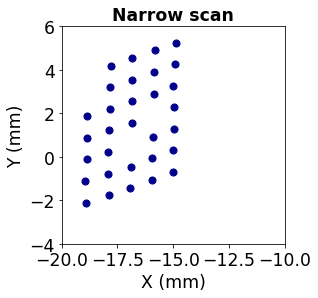

In [105]:
slope_mag=10
fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot(111)
plotpointswithdispaxis(ax,Xdata,Ydata,alphadata,slope_mag=slope_mag,mcolor="darkblue",dx=0)
ax.set_xlim(-20,-10)
ax.set_ylim(-4,6)
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
title="Narrow scan"
ax.set_title(title,fontweight="bold")
#ax.grid(color="grey")

## Wide scan, position and angle with DS9

In [42]:
filedata="../data/orientations/orientations-holo-26nov2021.xlsx"
df2=pd.read_excel(filedata,index_col=None,header=80)

In [43]:
df2

,précision 1pix,Unnamed: 1,Xp,Yp,Xq,Yq,Xc,Yc,Unnamed: 8,Unnamed: 9,...,Xhc,Yhc,Dx,Dy,alpha,X(mm),Y(mm),degré,dalpha,d(760nm)
0,NaN,253,3599.0,599.0,3623.0,3970.0,3600.0,693.0,NaN,NaN,...,-1307,-1564,3371,-24,-0.007119,-13.07,-15.64,-0.407914,0.067987,NaN
1,NaN,254,3018.0,278.0,3040.0,3993.0,3022.0,707.0,NaN,NaN,...,-1293,-986,3715,-22,-0.005922,-12.93,-9.86,-0.339298,0.061691,NaN
2,NaN,255,2413.0,299.0,2413.0,3965.0,2413.0,690.0,NaN,NaN,...,-1310,-377,3666,0,0.000000,-13.10,-3.77,0.000000,0.062516,NaN
3,NaN,256,1807.0,134.0,1797.0,3993.0,1806.0,674.0,NaN,NaN,...,-1326,230,3859,10,0.002591,-13.26,2.30,0.148473,0.059389,NaN
4,NaN,257,1210.0,48.0,1178.0,3994.0,1205.0,662.0,NaN,NaN,...,-1338,831,3946,32,0.008109,-13.38,8.31,0.464629,0.058080,NaN
5,NaN,258,601.0,127.0,563.0,3984.0,595.0,649.0,NaN,NaN,...,-1351,1441,3857,38,0.009852,-13.51,14.41,0.564473,0.059420,NaN
6,NaN,259,3734.0,24.0,3759.0,3980.0,3742.0,1303.0,NaN,NaN,...,-697,-1706,3956,-25,-0.006319,-6.97,-17.06,-0.362077,0.057933,NaN
7,NaN,260,3133.0,6.0,3147.0,3997.0,3138.0,1289.0,NaN,NaN,...,-711,-1102,3991,-14,-0.003508,-7.11,-11.02,-0.200987,0.057425,NaN
8,NaN,261,2535.0,8.0,2535.0,3988.0,2535.0,1279.0,NaN,NaN,...,-721,-499,3980,0,0.000000,-7.21,-4.99,0.000000,0.057584,NaN
9,NaN,262,1933.0,49.0,1922.0,3985.0,1930.0,1271.0,NaN,NaN,...,-729,106,3936,11,0.002795,-7.29,1.06,0.160125,0.058227,NaN


In [44]:
df2 = df2[['X(mm)', 'Y(mm)','degré','dalpha']]

In [45]:
df2["X(mm)"] = - df2["X(mm)"].values 
df2["degré"] = - df2["degré"].values

<ipython-input-45-777b1859fc13>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["X(mm)"] = - df2["X(mm)"].values
<ipython-input-45-777b1859fc13>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["degré"] = - df2["degré"].values


### Drop NA

In [47]:
df2.dropna(axis=0,how='any',inplace=True)

<ipython-input-47-1c743cb4f771>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.dropna(axis=0,how='any',inplace=True)


## Extract data

In [48]:
NumberofPointsData2=len(df2)

Xdata2=df2["X(mm)"].values
Ydata2=df2["Y(mm)"].values
alphadata2=df2["degré"].values
alphaerrdata2=df2["dalpha"].values

Text(0.5, 1.0, 'Wide scan')

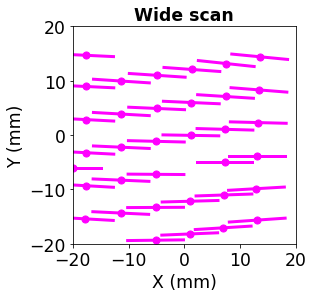

In [106]:
slope_mag=10
fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot(111)
plotpointswithdispaxis(ax,Xdata2,Ydata2,alphadata2,slope_mag=slope_mag,mcolor="magenta",bcolor="magenta",dx=5)
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
title="Wide scan"
ax.set_title(title,fontweight="bold")
#ax.grid(color="grey")

# Comparison of Neff in Data and model

In [50]:
c_X_Oh  = -14.09  # mm , x-coordinates of the hologram optical center in the CCD ref frame
c_Y_Oh  = 4.27 # mm , y-coordinate of the hologram optical center in the CCD ref frame
c_beta0 = -0.28 #degree , angle of rotation of hologram source axis wrt CCD  

## Phase difference

In [51]:
X_ccd = np.linspace(XMIN, XMAX, NPIX)
Y_ccd = np.linspace(YMIN, YMAX, NPIX)
XX_ccd, YY_ccd = np.meshgrid(X_ccd, Y_ccd, sparse=False)

# homothetie toward hologram plane
xx_holo=XYtoxy(XX_ccd,c_Z0) 
yy_holo=XYtoxy(YY_ccd,c_Z0) 
# homothetie of point Oh projected in hologram plane
x_Oh,y_Oh=XYtoxy_2D(c_X_Oh,c_Y_Oh,c_Z0)

# rotation from CCD orientation toward hologram 
(xx1_holo,yy1_holo)=xytox1y1_2D(xx_holo,yy_holo,c_beta0,x_Oh,y_Oh)
Z_Phi_ccd=dd_phi(xx1_holo,yy1_holo) # compute dispersion angle inside hologram frame

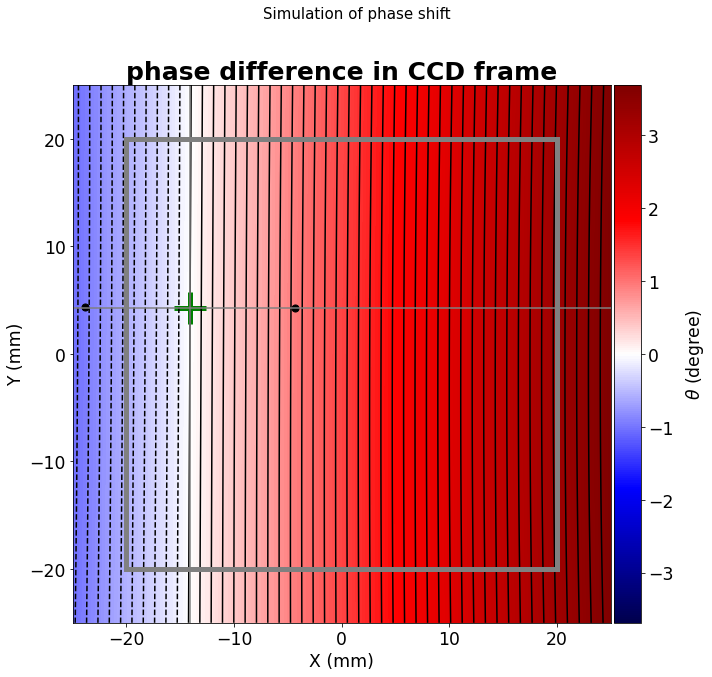

In [52]:
fig = plt.figure(figsize=(10,10))

xy1_A=np.array([-c_d1/2,0])
xy1_B=np.array([c_d1/2,0])
xy1_Oh=np.array([0,0])


# relative phase difference in CCD frame when hologram is rotated by an angle beta
ax = fig.add_subplot(111)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
maxPhi=np.max(np.abs(Z_Phi_ccd))

im=ax.imshow(Z_Phi_ccd,origin="lower",cmap="seismic",extent=(XMIN,XMAX,YMIN,YMAX),vmin=-maxPhi,vmax=maxPhi)
h = ax.contour(X_ccd,Y_ccd,Z_Phi_ccd,levels=50,colors='k')
# ax.clabel(h, inline=True, fontsize=12)
cbar=fig.colorbar(im,cax=cax)

cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel('$\\theta$ (degree)', rotation=90)

# inverse rotation from hologram frame to frame in which axis are parralel in 
xy_A = x1y1toxy(xy1_A,c_beta0,x_Oh,y_Oh)
xy_B = x1y1toxy(xy1_B,c_beta0,x_Oh,y_Oh)
xy_Oh = x1y1toxy(xy1_Oh,c_beta0,x_Oh,y_Oh)

# inverse homothetie
XY_A = xytoXY(xy_A,c_Z0)
XY_B = xytoXY(xy_B,c_Z0)
XY_Oh = xytoXY(xy_Oh,c_Z0)

ax.scatter(XY_A[0],XY_A[1],marker="o",color="k",s=50)
ax.scatter(XY_B[0],XY_B[1],marker="o",color="k",s=50)
ax.scatter(XY_Oh[0],XY_Oh[1],marker="+",color="g",s=1000,lw=5)

ax.axvline(x=c_X_Oh,color="grey")
ax.axhline(y=c_Y_Oh,color="grey")

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_title("phase difference in CCD frame",fontweight="bold",fontsize=25)

# CCD border
ax.plot([-20,-20],[-20,20],color="grey",lw=5)
ax.plot([20,20],[-20,20],color="grey",lw=5)
ax.plot([-20,20],[-20,-20],color="grey",lw=5)
ax.plot([-20,20],[20,20],color="grey",lw=5)


plt.suptitle("Simulation of phase shift",fontsize=15)
plt.tight_layout()

## Dispersion angle

In [53]:
Z_Ang_holo=dd_alpha(XX,YY)

In [54]:
X_ccd = np.linspace(XMIN, XMAX, NPIX)
Y_ccd = np.linspace(YMIN, YMAX, NPIX)
XX_ccd, YY_ccd = np.meshgrid(X_ccd, Y_ccd, sparse=False)

# homothetie toward hologram plane
xx_holo=XYtoxy(XX_ccd,c_Z0) 
yy_holo=XYtoxy(YY_ccd,c_Z0) 

# homothetie of point Oh in hologram plane
x_Oh,y_Oh=XYtoxy_2D(c_X_Oh,c_Y_Oh,c_Z0)

# rotation from CCD orientation toward hologram 
(xx1_holo,yy1_holo)=xytox1y1_2D(xx_holo,yy_holo,c_beta0,x_Oh,y_Oh)

# calcul of dispersion angle in hologram frame
Z_Ang_ccd=dd_alpha(xx1_holo,yy1_holo)

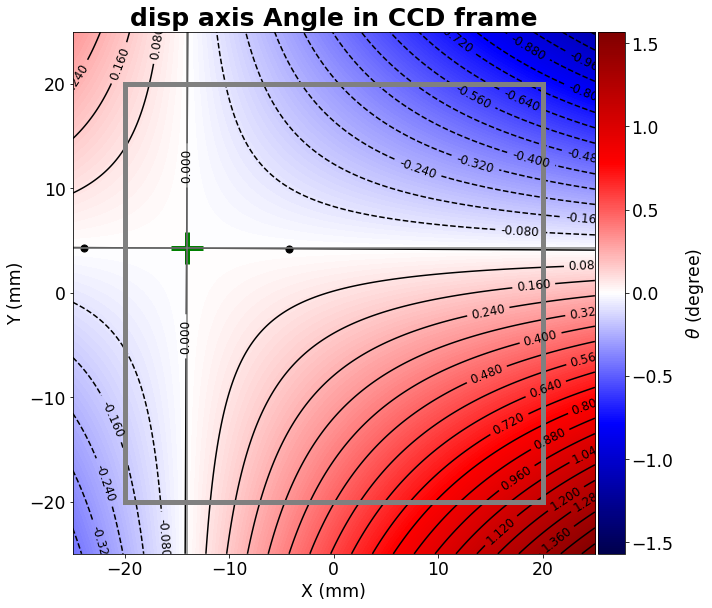

In [55]:
fig = plt.figure(figsize=(10,10))

# dispersion axis in hologram frame (Oh,x1,y1)

xy1_A=np.array([-c_d1/2,0])
xy1_B=np.array([c_d1/2,0])
xy1_Oh=np.array([0,0])


ax = fig.add_subplot(111)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

maxAng=np.max(np.abs(Z_Ang_ccd))
im=ax.imshow(Z_Ang_ccd,origin="lower",cmap="seismic",extent=(XMIN,XMAX,YMIN,YMAX),vmin=-maxAng,vmax=maxAng)
h = ax.contour(X_ccd,Y_ccd,Z_Ang_ccd,levels=40,colors='k')
ax.clabel(h, inline=True, fontsize=12)
cbar=fig.colorbar(im,cax=cax)

cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel('$\\theta$ (degree)', rotation=90)

# inverse rotation
xy_A = x1y1toxy(xy1_A,c_beta0,x_Oh,y_Oh)
xy_B = x1y1toxy(xy1_B,c_beta0,x_Oh,y_Oh)
xy_Oh = x1y1toxy(xy1_Oh,c_beta0,x_Oh,y_Oh)

# inverse homothetie
XY_A = xytoXY(xy_A,c_Z0)
XY_B = xytoXY(xy_B,c_Z0)
XY_Oh = xytoXY(xy_Oh,c_Z0)

ax.scatter(XY_A[0],XY_A[1],marker="o",color="k",s=50)
ax.scatter(XY_B[0],XY_B[1],marker="o",color="k",s=50)
ax.scatter(XY_Oh[0],XY_Oh[1],marker="+",color="g",s=1000,lw=5)

ax.axvline(x=c_X_Oh,color="grey")
ax.axhline(y=c_Y_Oh,color="grey")

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_title("disp axis Angle in CCD frame",fontweight="bold",fontsize=25)

# CCD border
ax.plot([-20,-20],[-20,20],color="grey",lw=5)
ax.plot([20,20],[-20,20],color="grey",lw=5)
ax.plot([-20,20],[-20,-20],color="grey",lw=5)
ax.plot([-20,20],[20,20],color="grey",lw=5)


plt.tight_layout()

## Line density

In [56]:
Z_N_holo=N_density(XX,YY)

In [57]:
X_ccd = np.linspace(XMIN, XMAX, NPIX)
Y_ccd = np.linspace(YMIN, YMAX, NPIX)
XX_ccd, YY_ccd = np.meshgrid(X_ccd, Y_ccd, sparse=False)

# homothetie toward hologram plane
xx_holo=XYtoxy(XX_ccd,c_Z0) 
yy_holo=XYtoxy(YY_ccd,c_Z0) 
# homothetie of point Oh projected in hologram plane
x_Oh,y_Oh=XYtoxy_2D(c_X_Oh,c_Y_Oh,c_Z0)

# rotation from CCD orientation toward hologram 
(xx1_holo,yy1_holo)=xytox1y1_2D(xx_holo,yy_holo,c_beta0,x_Oh,y_Oh)
Z_N_ccd=N_density(xx1_holo,yy1_holo) # compute line density inside hologram frame

In [58]:
df_neff = df_neff[ df_neff["Neff"] != 0 ]
all_x = df_neff["X(mm)"].values
all_y = df_neff["Y(mm)"].values
all_neff= df_neff["Neff"].values
all_nefferr= df_neff["Nefferr"].values
nn=len(df_neff)
nn

31

In [59]:
all_neff

array([152.0470186 , 152.13167843, 152.29756991, 152.09340092,
       152.49494828, 152.21901384, 152.52034019, 152.06406628,
       152.08846041, 152.05637858, 152.27358792, 152.2421162 ,
       151.93221615, 152.37016877, 152.1737753 , 152.20096492,
       152.12002009, 152.16749359, 151.92703466, 151.96673888,
       152.07168311, 152.05729766, 152.0165788 , 152.01150316,
       151.82844934, 151.95103778, 151.53769304, 152.03429267,
       152.03551603, 152.12460913, 152.03536346])

In [60]:
all_neff

array([152.0470186 , 152.13167843, 152.29756991, 152.09340092,
       152.49494828, 152.21901384, 152.52034019, 152.06406628,
       152.08846041, 152.05637858, 152.27358792, 152.2421162 ,
       151.93221615, 152.37016877, 152.1737753 , 152.20096492,
       152.12002009, 152.16749359, 151.92703466, 151.96673888,
       152.07168311, 152.05729766, 152.0165788 , 152.01150316,
       151.82844934, 151.95103778, 151.53769304, 152.03429267,
       152.03551603, 152.12460913, 152.03536346])

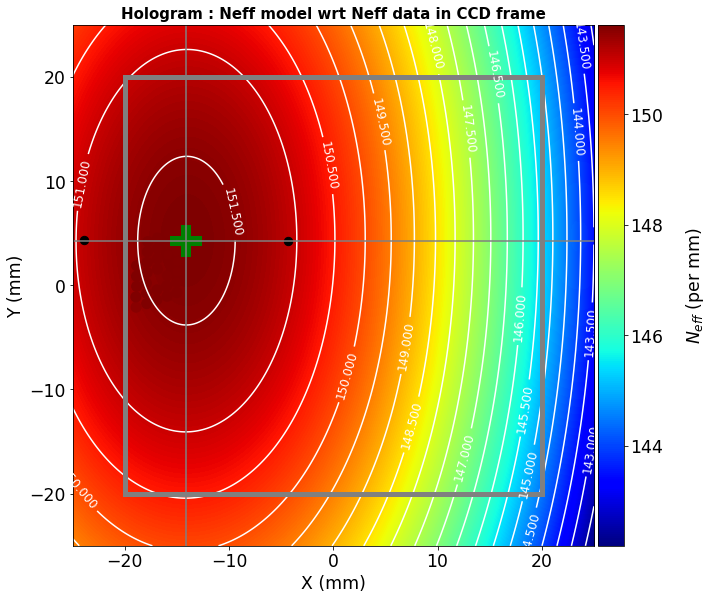

In [61]:
fig = plt.figure(figsize=(10,10))


xy1_A=np.array([-c_d1/2,0])
xy1_B=np.array([c_d1/2,0])
xy1_Oh=np.array([0,0])


ax = fig.add_subplot(111)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

maxN=np.max(Z_N_ccd)
minN=np.min(Z_N_ccd)




im=ax.imshow(Z_N_ccd,origin="lower",cmap="jet",extent=(XMIN,XMAX,YMIN,YMAX),vmin=minN,vmax=maxN)
h = ax.contour(X_ccd,Y_ccd,Z_N_ccd,levels=20,colors='w')
ax.clabel(h, inline=True, fontsize=12)

cbar=fig.colorbar(im,cax=cax)

cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('$N_{eff}$ (per mm)', rotation=90)

# inverse rotation
xy_A = x1y1toxy(xy1_A,c_beta0,x_Oh,y_Oh)
xy_B = x1y1toxy(xy1_B,c_beta0,x_Oh,y_Oh)
xy_Oh = x1y1toxy(xy1_Oh,c_beta0,x_Oh,y_Oh)

# inverse homothetie
XY_A = xytoXY(xy_A,c_Z0)
XY_B = xytoXY(xy_B,c_Z0)
XY_Oh = xytoXY(xy_Oh,c_Z0)

ax.scatter(XY_A[0],XY_A[1],marker="o",color="k",s=70)
ax.scatter(XY_B[0],XY_B[1],marker="o",color="k",s=70)


ax.axvline(x=c_X_Oh,color="grey")
ax.axhline(y=c_Y_Oh,color="grey")
ax.scatter(XY_Oh[0],XY_Oh[1],marker="+",color="g",s=1000,lw=10)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_title("Hologram : Neff model wrt Neff data in CCD frame",fontweight="bold",fontsize=15)


ax.scatter(all_x,all_y,s=100,c=all_neff, cmap="jet",vmin=minN,vmax=maxN)
  
ax.scatter(XY_Oh[0],XY_Oh[1],marker="+",color="g",s=1000,lw=10)

    
# CCD border
ax.plot([-20,-20],[-20,20],color="grey",lw=5)
ax.plot([20,20],[-20,20],color="grey",lw=5)
ax.plot([-20,20],[-20,-20],color="grey",lw=5)
ax.plot([-20,20],[20,20],color="grey",lw=5)



plt.tight_layout()

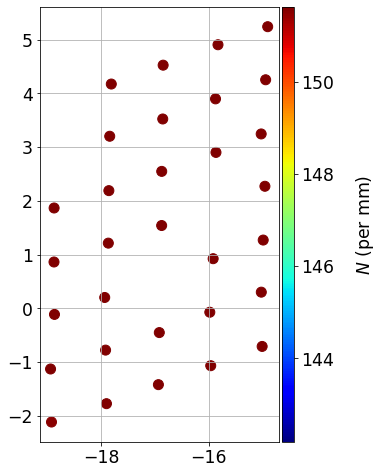

In [62]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)


im=ax.scatter(all_x,all_y,s=100,c=all_neff,cmap="jet",vmin=minN,vmax=maxN)

ax.set_aspect("equal")
cbar=fig.colorbar(im,cax=cax)

cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('$N$ (per mm)', rotation=90)
ax.grid()

# Fit Neff

## Optimisation of Neff max value

In [63]:
def chi2func_Neff(Xdata,Ydata,Zdata,Zerrdata,neffmaxparam,X0,Y0,beta,Z,Npar=1):
    """
    Total Chi2, do not divide by the number of data points 
    
    - input parameters
      - Xdata,Ydata :three 1D-numpy array: Xdata,Ydata coordinates of order zero, 
      - Zdata : Neff measurement
      - Zerrdata : error on Neff
      - X0,Y0  geometric center of hologram in CCD frame
      - beta, rotation
      - Z distance holo - CCD
     
      - Npar : number of parameter to use in degrees of freedom
      
    - ouput
     - 2D numpy array of chi2 representing the chi2
     
    """
    
   
    N=len(Xdata)
    chi2=0
 
    # loop on data
    for idx in np.arange(N):
        
        X=Xdata[idx] # scalar
        Y=Ydata[idx]
        
        XY=np.array([X,Y])
        
        # homothecie according with homothetie
        xy=XYtoxy(XY,Z)
        x0,y0=XYtoxy_2D(X0,Y0,Z)
        
          
        # rotation according the beta assumption
        x1y1=xytox1y1(xy,beta,x0,y0)

        
        #calculation of dispersion angle in hologram frame according the model
        #d_alpha=dd_alpha(x1y1[0],x1y1[1])
        
         # Calculation of expected Neff
        neff_mod = FuncFitDensity(x1y1[0],x1y1[1],neffmaxparam)
        
       
        
        #Neff measured measured in CCD frame
        neff_mes=Zdata[idx]
    
        # error
        sig=Zerrdata[idx]
    
        if sig!=0:
            chi2+=(neff_mod-neff_mes)**2/sig**2
        
        
    return chi2 

In [64]:
param_neff=np.linspace(100,200,500)
Xdata= all_x 
Ydata= all_y
Zdata=all_neff
Zerrdata=all_nefferr
Ndata=len(Xdata)

In [65]:
thechi2 = [ chi2func_Neff(Xdata,Ydata,Zdata,Zerrdata,neffmaxparam,c_X_Oh,c_Y_Oh,c_beta0 ,c_Z0,Npar=1) for neffmaxparam in param_neff]

In [66]:
thechi2=np.array(thechi2)

In [67]:
idx_chi2min= np.where(thechi2 == thechi2.min())[0][0]
idx_chi2min

260

In [68]:
neff_chi2min=param_neff[idx_chi2min]

In [69]:
thechi2.min()/Ndata

1.9355905478098732

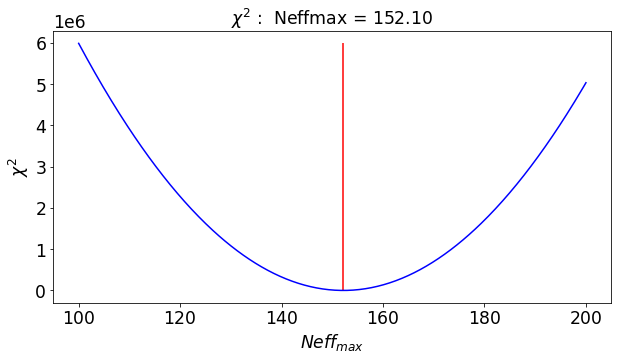

In [70]:
################# Fig 2
    
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
    
fig = plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax.plot(param_neff,thechi2,'b-')
ax.set_xlabel("$Neff_{max}$")
ax.set_ylabel("$\chi^2$")
ax.set_title(f"$\chi^2$ :  Neffmax = {neff_chi2min:.2f} ")
ax.vlines(neff_chi2min, ymin=0, ymax=thechi2.max(), colors='r')

plt.show()


## Correction factor of Neff

In [71]:
neff_chi2min/N_density(0,0)

1.003183866188871

## Comparison of data wrt corrected model

In [72]:
Z_N_ccd_fitted=N_density(xx1_holo,yy1_holo)*neff_chi2min/N_density(0,0) # compute line density inside hologram frame

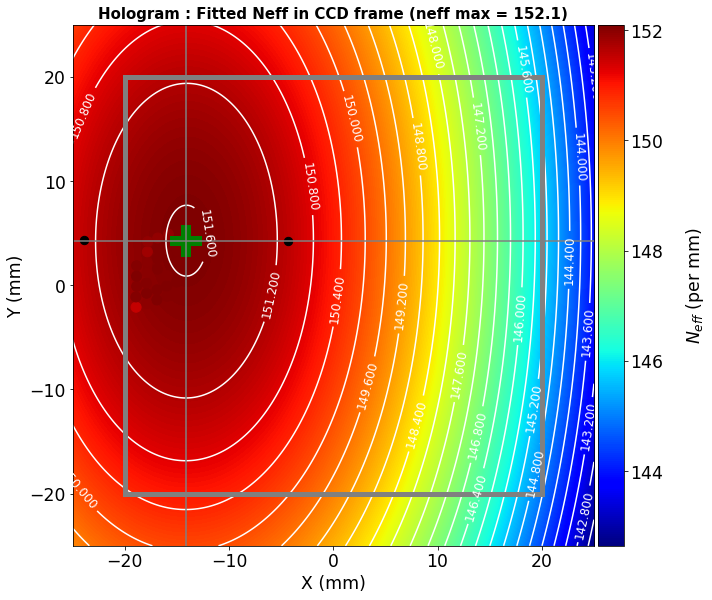

In [73]:
fig = plt.figure(figsize=(10,10))


xy1_A=np.array([-c_d1/2,0])
xy1_B=np.array([c_d1/2,0])
xy1_Oh=np.array([0,0])


ax = fig.add_subplot(111)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

maxN=np.max(Z_N_ccd_fitted)
minN=np.min(Z_N_ccd_fitted)




im=ax.imshow(Z_N_ccd_fitted,origin="lower",cmap="jet",extent=(XMIN,XMAX,YMIN,YMAX),vmin=minN,vmax=maxN)
h = ax.contour(X_ccd,Y_ccd,Z_N_ccd,levels=30,colors='w')
ax.clabel(h, inline=True, fontsize=12)

cbar=fig.colorbar(im,cax=cax)

cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('$N_{eff}$ (per mm)', rotation=90)

# inverse rotation
xy_A = x1y1toxy(xy1_A,c_beta0,x_Oh,y_Oh)
xy_B = x1y1toxy(xy1_B,c_beta0,x_Oh,y_Oh)
xy_Oh = x1y1toxy(xy1_Oh,c_beta0,x_Oh,y_Oh)

# inverse homothetie
XY_A = xytoXY(xy_A,c_Z0)
XY_B = xytoXY(xy_B,c_Z0)
XY_Oh = xytoXY(xy_Oh,c_Z0)

ax.scatter(XY_A[0],XY_A[1],marker="o",color="k",s=70)
ax.scatter(XY_B[0],XY_B[1],marker="o",color="k",s=70)


ax.axvline(x=c_X_Oh,color="grey")
ax.axhline(y=c_Y_Oh,color="grey")
ax.scatter(XY_Oh[0],XY_Oh[1],marker="+",color="g",s=1000,lw=10)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_title(f"Hologram : Fitted Neff in CCD frame (neff max = {neff_chi2min:0.1f})",fontweight="bold",fontsize=15)


ax.scatter(all_x,all_y,s=100,c=all_neff, cmap="jet",vmin=minN,vmax=maxN)
  
ax.scatter(XY_Oh[0],XY_Oh[1],marker="+",color="g",s=1000,lw=10)

    
# CCD border
ax.plot([-20,-20],[-20,20],color="grey",lw=5)
ax.plot([20,20],[-20,20],color="grey",lw=5)
ax.plot([-20,20],[-20,-20],color="grey",lw=5)
ax.plot([-20,20],[20,20],color="grey",lw=5)

plt.tight_layout()

# Figure for DESC meeting

<ipython-input-95-5820d6569d29>:16: UserWarning: The following kwargs were not used by contour: 'lw'
  h = ax.contour(X_ccd,Y_ccd,Z_Phi_ccd,levels=50,colors='grey',lw=100)


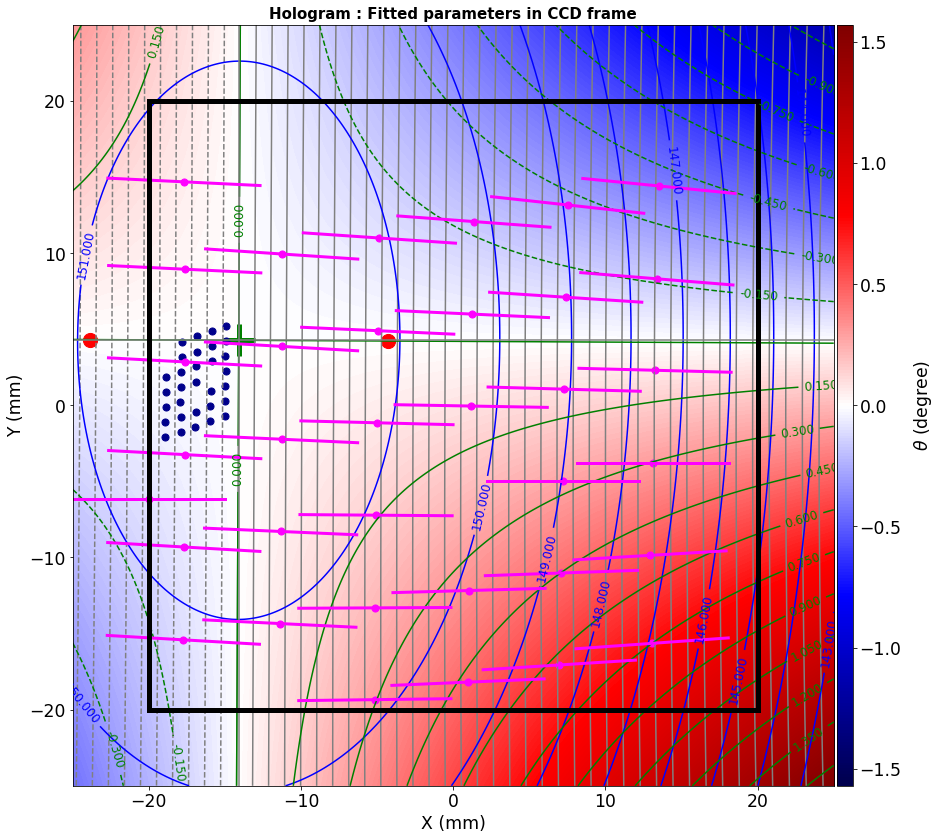

In [95]:
fig = plt.figure(figsize=(14,14))


xy1_A=np.array([-c_d1/2,0])
xy1_B=np.array([c_d1/2,0])
xy1_Oh=np.array([0,0])


ax = fig.add_subplot(111)



divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)

h = ax.contour(X_ccd,Y_ccd,Z_Phi_ccd,levels=50,colors='grey',lw=100)


#### Neff
#maxN=np.max(Z_N_ccd_fitted)
#minN=np.min(Z_N_ccd_fitted)

h = ax.contour(X_ccd,Y_ccd,Z_N_ccd,levels=10,colors='b')
ax.clabel(h, inline=True, fontsize=12)


## Dispersion angle 
maxAng=np.max(np.abs(Z_Ang_ccd))
im=ax.imshow(Z_Ang_ccd,origin="lower",cmap="seismic",extent=(XMIN,XMAX,YMIN,YMAX),vmin=-maxAng,vmax=maxAng)
h = ax.contour(X_ccd,Y_ccd,Z_Ang_ccd,levels=20,colors='green')
ax.clabel(h, inline=True, fontsize=12)
cbar=fig.colorbar(im,cax=cax)

cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel('$\\theta$ (degree)', rotation=90)





## Fitted geometry

# inverse rotation
xy_A = x1y1toxy(xy1_A,c_beta0,x_Oh,y_Oh)
xy_B = x1y1toxy(xy1_B,c_beta0,x_Oh,y_Oh)
xy_Oh = x1y1toxy(xy1_Oh,c_beta0,x_Oh,y_Oh)

# inverse homothetie
XY_A = xytoXY(xy_A,c_Z0)
XY_B = xytoXY(xy_B,c_Z0)
XY_Oh = xytoXY(xy_Oh,c_Z0)

ax.scatter(XY_A[0],XY_A[1],marker="o",color="r",s=200)
ax.scatter(XY_B[0],XY_B[1],marker="o",color="r",s=200)


ax.axvline(x=c_X_Oh,color="grey")
ax.axhline(y=c_Y_Oh,color="grey")
ax.scatter(XY_Oh[0],XY_Oh[1],marker="+",color="g",s=1000,lw=5)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_title(f"Hologram : Fitted parameters in CCD frame",fontweight="bold",fontsize=15)



# points narrow scan
#ax.scatter(all_x,all_y,s=20,c="green")

plotpointswithdispaxis(ax,Xdata,Ydata,alphadata,slope_mag=10,mcolor="darkblue",dx=0)


# wide scan
plotpointswithdispaxis(ax,Xdata2,Ydata2,alphadata2,slope_mag=10,mcolor="magenta",bcolor="magenta",dx=5)


# CCD border
ax.plot([-20,-20],[-20,20],color="k",lw=5)
ax.plot([20,20],[-20,20],color="k",lw=5)
ax.plot([-20,20],[-20,-20],color="k",lw=5)
ax.plot([-20,20],[20,20],color="k",lw=5)
